<a href="https://colab.research.google.com/github/hamidahoderinwale/model_metadata_analyses/blob/main/scraping_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script 1
Takes in a (validated) model url and output its metadata

In [ ]:
# Script 1: takes input model url, validates url, and gives model metadata
!pip install validators
from huggingface_hub import HfApi
import huggingface_hub as hf
import validators
import json
import csv

hf_api = HfApi()

def input_url():
    while True:
        input_model_url = input("Enter model URL: ")
        print(f"You entered: {input_model_url}")

        if validators.url(input_model_url) and "huggingface.co" in input_model_url:
            try:
                # Extract the model ID from the URL
                model_id = input_model_url.split("huggingface.co/")[-1]
                model_info = hf_api.model_info(model_id) # Get model info: https://huggingface.co/docs/huggingface_hub/v0.29.2/en/package_reference/hf_api#huggingface_hub.ModelInfo
                json_output = json.dumps(model_card.__dict__, indent=4, default=str)
                print(json_output)
                with open('model_info.json', 'w') as json_file:
                    json_file.write(json_output)
            except Exception as e:
                    print(f"Error fetching model info: {str(e)}")
            for key, value in model_info.__dict__.items():
                    print(f"{key}: {value}")
                    return model_info

        else:
            print("Invalid URL. Please enter a valid Hugging Face model URL.") # error code

# Call the function
model_info = input_url()

# To test: https://huggingface.co/deepseek-ai/DeepSeek-R1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00


# Script 2
Takes in a (validated) model and outputs the children models/fine-tunes

In [ ]:
# Script 2
  # 1. Take link as input (format check). This is the "main model"
  # 2. Give the link to the page with the fine-tunes for the inputted model

from huggingface_hub import HfApi
import requests
from bs4 import BeautifulSoup
import re

# Initialize API
api = HfApi()

# Function to validate Hugging Face model URL
def validate_hf_model_url(url):
    pattern = r"^https://huggingface.co/([\w\-]+)/([\w\-]+)$"
    match = re.match(pattern, url)
    if match:
        return match.groups()  # Returns (org/user, model_name)
    return None

# Function to find fine-tuned models
def get_finetuned_models_page(model_org, model_name):
    search_url = f"https://huggingface.co/models?search={model_name}"
    response = requests.get(search_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        model_links = [
            a["href"] for a in soup.find_all("a", href=True)
            if model_name.lower() in a["href"].lower()
        ]
        return [f"https://huggingface.co{link}" for link in model_links if model_org not in link]

    return []

# Main execution
model_url = input("Enter the Hugging Face model URL: ").strip()

validated = validate_hf_model_url(model_url)
if validated:
    org, model_name = validated
    finetune_links = get_finetuned_models_page(org, model_name)

    if finetune_links:
        print("Fine-tuned models found:")
        for link in finetune_links:
            print(link)
    else:
        print("No fine-tuned models found for this model.")
else:
    print("Invalid Hugging Face model URL format.")



Enter the Hugging Face model URL: https://huggingface.co/perplexity-ai/r1-1776
Fine-tuned models found:
https://huggingface.co/lmstudio-community/r1-1776-GGUF
https://huggingface.co/unsloth/r1-1776-GGUF
https://huggingface.co/unsloth/r1-1776
https://huggingface.co/huihui-ai/r1-1776-GGUF
https://huggingface.co/mlx-community/r1-1776-distill-llama-70b-8bit
https://huggingface.co/mlx-community/r1-1776-distill-llama-70b-4bit
https://huggingface.co/matatonic/r1-1776-distill-llama-70b-6.5bpw-h8-exl2
https://huggingface.co/mmnga/r1-1776-distill-llama-70b-gguf
https://huggingface.co/unsloth/r1-1776-distill-llama-70b
https://huggingface.co/second-state/r1-1776-distill-llama-70b-GGUF
https://huggingface.co/unsloth/r1-1776-distill-llama-70b-GGUF
https://huggingface.co/unsloth/r1-1776-distill-llama-70b-unsloth-bnb-4bit
https://huggingface.co/lmstudio-community/r1-1776-distill-llama-70b-GGUF
https://huggingface.co/mradermacher/r1-1776-distill-llama-70b-i1-GGUF
https://huggingface.co/Apel-sin/r1-1776

# Script 3
## Search steps overview
- `dfs_finetunes` we take the `model_url` as input. Alternatively, we can add this var as an argument.
- We go layer-by-layer and find the children of the current model (i.e. the fine-tunes of a model)
- We call the `dfs_funetunes` function recursively and store the models that have been "visited" to avoid duplicates.
- We have a dictionary of information that we store about the "current model" and have the information stored in respective columns.
- We have a `results` list that has the information about all the models and their fine-tunes.

In [ ]:
# Script 3
import requests
import pandas as pd
import datetime
import json
import csv
from huggingface_hub import HfApi
from bs4 import BeautifulSoup
import re

# Initialize API
api = HfApi()

# Function to validate Hugging Face model URL
def validate_hf_model_url(url):
    pattern = r"^https://huggingface.co/([\w\-]+)/([\w\-]+)$"
    match = re.match(pattern, url)
    return match.groups() if match else None


# Function to find fine-tuned models
def get_finetuned_models_page(model_org, model_name):
    search_url = f"https://huggingface.co/models?other=base_model:finetune:{model_org}/{model_name}"
    response = requests.get(search_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        model_divs = soup.find_all("div", class_="w-full truncate")
        model_links = []
        for div in model_divs:
            header = div.find("header")
            if header:
                model_link = header.get("title")
                if model_link:
                    model_links.append(f"https://huggingface.co/{model_link}")
        return model_links
    return []

# Function to get parent model
def get_parent_model(model_url):
    return model_url.split(f"/{model_name}/")[0]

# Truncate metadata
def filter_metadata(json_metadata):
            keys_to_keep = ["modelId", "sha", "tags", "downloads", "pipeline_tag"]
            return {k: json_metadata.get(k) for k in keys_to_keep if k in json_metadata}
            filtered_metadata = filter_metadata(api.model_info(model_id).__dict__)

# Recursive DFS (depth-first search) for finding fine-tunes
def dfs_finetunes(model_url, visited, depth=0, results=None):
       if results is None:
           results = []

       if model_url in visited:
           return results
       visited.add(model_url)

       validated = validate_hf_model_url(model_url)
       if not validated:
           print(f"Invalid URL skipped: {model_url}")
           model_url = "N/A"
           return results

       model_org, model_name = validated
       model_id = f"{model_org}/{model_name}"


       print(f"\n{'  ' * depth}Fetching metadata for: {model_id}")
       try:
           model_metadata = api.model_info(model_id).__dict__
           json_metadata = json.dumps(model_metadata, default=str)

       except Exception as e:
           print(f"Error fetching metadata: {e}")
           return results

       finetune_links = get_finetuned_models_page(model_org, model_name)
       # Removing Duplicate Children
       finetune_links = list(set(finetune_links))
       print(f"{'  ' * depth}Found {len(finetune_links)} fine-tunes at depth {depth}.")

       results.append({
           "model_id": model_id,
           "metadata": json_metadata,
           "depth": depth,
           "children": finetune_links,
           "children_count": len(finetune_links)
       })
       for link in finetune_links:
             dfs_finetunes(link, visited, depth + 1, results)

       return results


# Timestamp for the run
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Function to save results as JSON
def save_json(results, model_name):
    filename = f"{model_name}_finetunes_{timestamp}.json"
    data = {
        "models": results
    }
    with open(filename, "w") as f:
        json.dump(data, f, indent=4, default=str)
    print(f"Results saved to {filename}")

# Function to save results as CSV
''' def save_csv(results, model_name):
    filename = f"{model_name}_{timestamp}_finetunes.csv"
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["model_id", "depth", "children_count", "children", "metadata"])
        writer.writeheader()
        for entry in results:
            # Ensure metadata is a JSON string
            if isinstance(entry["metadata"], dict):
                entry["metadata"] = json.dumps(entry["metadata"], indent=2, default=str)
            # Join children list as a string
            entry["children"] = ", ".join(entry["children"])
            writer.writerow(entry)
    print(f"Results saved to {filename}") '''

# Function to save results as CSV (pandas)
def save_csv(results, model_name):
    filename = f"{model_name}_finetunes_{timestamp}.csv"
    df = pd.DataFrame(results)
    df.to_csv(filename, index=True)
    print(f"Results saved to {filename}")

# Main execution
if __name__ == "__main__":
    model_url = input("Enter the Hugging Face model URL: ").strip()
    visited = set()
    results = dfs_finetunes(model_url, visited)

    if results:
        model_name = results[0]["model_id"].split("/")[-1]  # Extract model name for file naming
        save_json(results, model_name)
        save_csv(results, model_name)
    else:
        print("No fine-tuned models found.")

'''Links for testing: https://huggingface.co/NousResearch/DeepHermes-3-Mistral-24B-Preview (3 fine-tunes at depth 0, 1 fine-tune at depth 1 for 'AlSamCur123/DeepHermes-3-Mistral-24BContinuedFine')
https://huggingface.co/perplexity-ai/r1-1776 (11 fine-tunes at depth 0)'''


# Script 4

Iteratively produces model tree datasets when given a list of models.

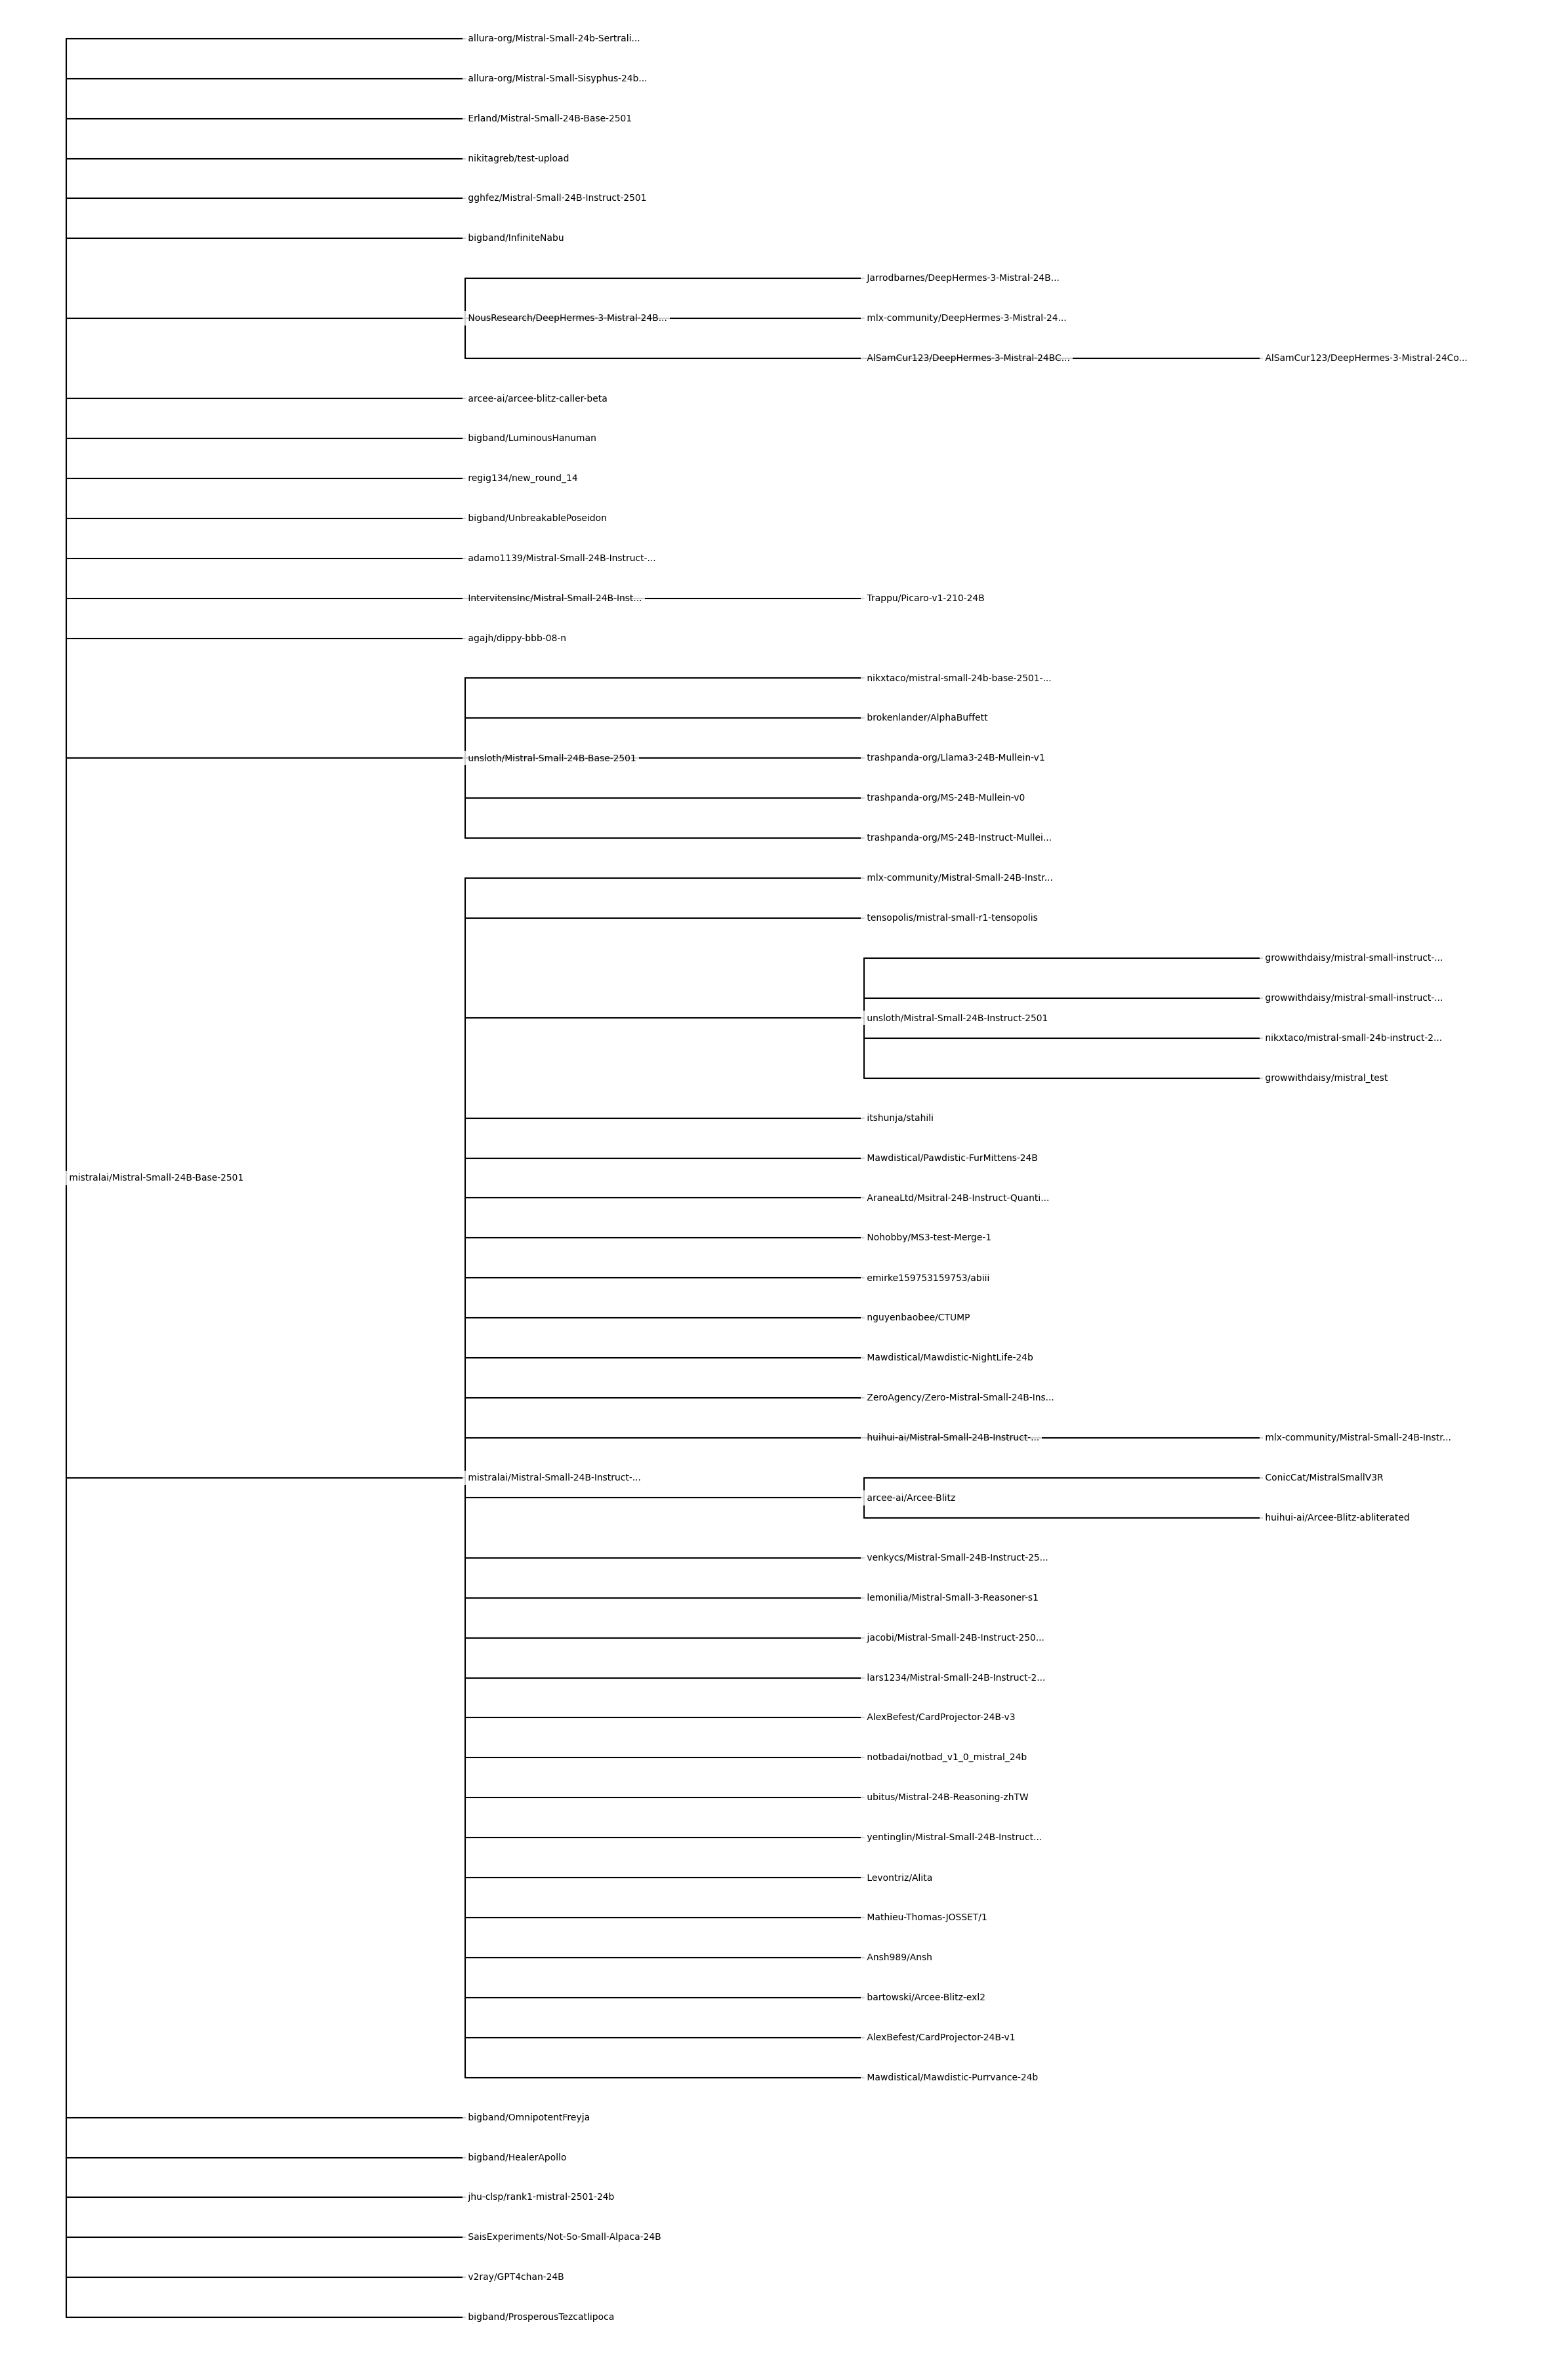

In [115]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from Bio import Phylo
from Bio.Phylo.BaseTree import Clade, Tree

# Load and prepare tree
df = pd.read_csv("Mistral-Small-24B-Base-2501_finetunes_20250405_001816.csv")
df['children'] = df['children'].apply(ast.literal_eval)

def build_phylo_tree_from_dfs(df):
    clade_map = {row['model_id']: Clade(name=row['model_id']) for _, row in df.iterrows()}
    parent_links = {}
    for _, row in df.iterrows():
        parent = row['model_id']
        for child_url in row['children']:
            child = '/'.join(child_url.split("/")[-2:])
            parent_links[child] = parent
    all_models = set(df['model_id'])
    child_models = set(parent_links.keys())
    root_model_id = list(all_models - child_models)[0]
    for child, parent in parent_links.items():
        if child in clade_map and parent in clade_map:
            clade_map[parent].clades.append(clade_map[child])
    return Tree(root=clade_map[root_model_id])

tree = build_phylo_tree_from_dfs(df)

# Plotting with labels on branches
fig = plt.figure(figsize=(24, 36))
ax = fig.add_subplot(1, 1, 1)

# Draw the tree without axes
Phylo.draw(tree, axes=ax, do_show=False)

# Remove all axes elements
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Ensure labels are positioned away from branch lines
for label in ax.texts:
    pos = label.get_position()
    label.set_position((pos[0], pos[1]))
    label.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3))

plt.tight_layout()
plt.savefig('clean_phylogenetic_tree.png', dpi=150, bbox_inches='tight')
plt.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


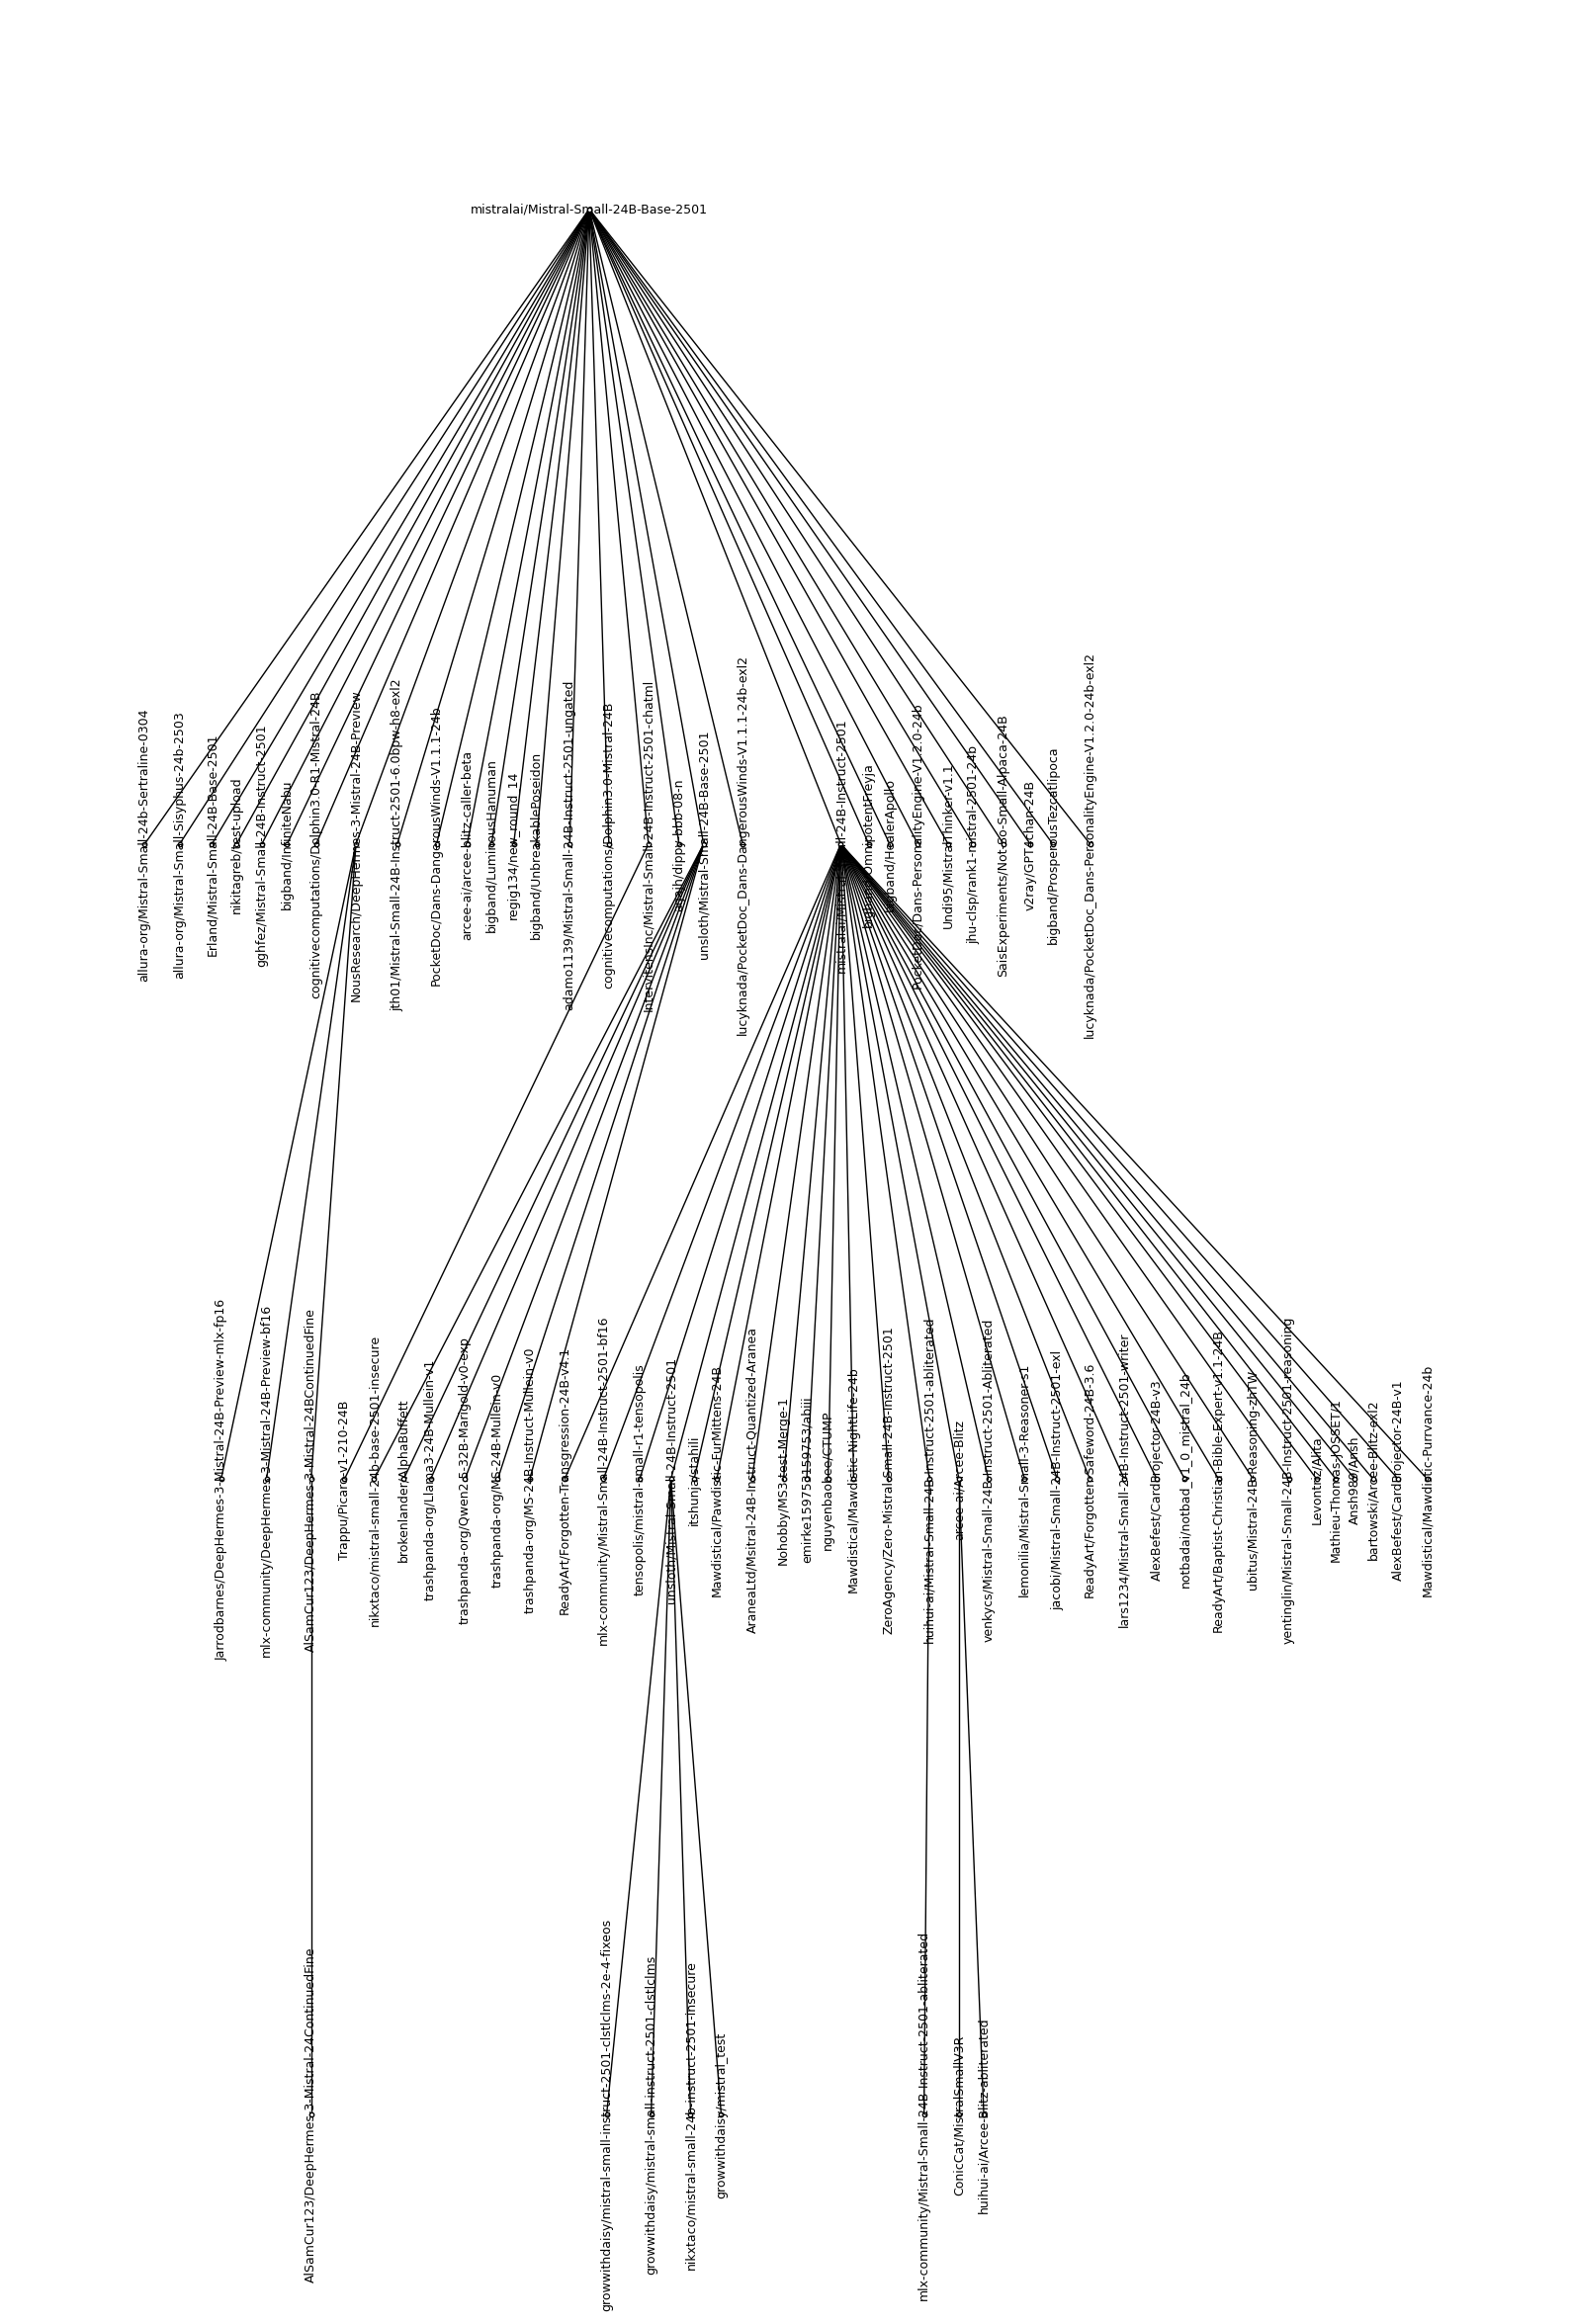

Tree visualization saved to mistral_finetune_tree_networkx.png


In [66]:
!apt install graphviz libgraphviz-dev
!pip install pygraphviz
import pandas as pd
import ast
import matplotlib.pyplot as plt
import networkx as nx

# Load and prepare the dataset
df = pd.read_csv("Mistral-Small-24B-Base-2501_finetunes_20250405_001816.csv")
df['children'] = df['children'].apply(ast.literal_eval)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in df.iterrows():
    parent = row['model_id']
    G.add_node(parent)
    for child_url in row['children']:
        child = '/'.join(child_url.split("/")[-2:])
        G.add_node(child)
        G.add_edge(parent, child)

# Find root node
root = [n for n, d in G.in_degree() if d == 0][0]

# Create a hierarchical layout
pos = nx.nx_agraph.graphviz_layout(G, prog='dot', root=root)

# Create figure
plt.figure(figsize=(16, 24))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='white', edgecolors='black')

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=False)

# Draw labels, rotating only non-root nodes
label_pos = {k: (v[0], v[1]) for k, v in pos.items()}
for node, (x, y) in label_pos.items():
    if node != root:  # Rotate labels for non-root nodes
        plt.text(x, y, s=node, rotation=90, ha='center', va='center', fontsize=9)
    else:  # Keep root label horizontal
        plt.text(x, y, s=node, ha='center', va='center', fontsize=9)

# Remove axes
plt.axis('off')
plt.tight_layout()

# Save the figure
plt.savefig("mistral_finetune_tree_networkx.png", dpi=150, bbox_inches='tight')
plt.show()

print("Tree visualization saved to mistral_finetune_tree_networkx.png")

In [116]:
# Script 5 (Batch DFS function)

import requests
import pandas as pd
import datetime
import json
import csv
from huggingface_hub import HfApi
from bs4 import BeautifulSoup
import re

api = HfApi()
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Validate Hugging Face model URL
def validate_hf_model_url(url):
    pattern = r"^https://huggingface.co/([\w\-]+)/([\w\-]+)$"
    match = re.match(pattern, url)
    return match.groups() if match else None

# Scrape Hugging Face model card page to find fine-tunes
def get_finetuned_models_page(model_org, model_name):
    search_url = f"https://huggingface.co/models?other=base_model:finetune:{model_org}/{model_name}"
    response = requests.get(search_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        model_divs = soup.find_all("div", class_="w-full truncate")
        model_links = []
        for div in model_divs:
            header = div.find("header")
            if header:
                model_link = header.get("title")
                if model_link:
                    model_links.append(f"https://huggingface.co/{model_link}")
        return model_links
    return []

# DFS for recursively discovering fine-tunes
def dfs_finetunes(model_url, visited, depth=0, results=None):
    if results is None:
        results = []

    if model_url in visited:
        return results
    visited.add(model_url)

    validated = validate_hf_model_url(model_url)
    if not validated:
        print(f"Invalid URL skipped: {model_url}")
        return results

    model_org, model_name = validated
    model_id = f"{model_org}/{model_name}"
    print(f"\n{'  '*depth}Fetching metadata for: {model_id}")

    try:
        model_metadata = api.model_info(model_id).__dict__
        json_metadata = json.dumps(model_metadata, default=str)
    except Exception as e:
        print(f"Error fetching metadata: {e}")
        return results

    finetune_links = get_finetuned_models_page(model_org, model_name)
    finetune_links = list(set(finetune_links))
    print(f"{'  '*depth}Found {len(finetune_links)} fine-tunes at depth {depth}.")

    results.append({
        "model_id": model_id,
        "metadata": json_metadata,
        "depth": depth,
        "children": finetune_links,
        "children_count": len(finetune_links)
    })

    for link in finetune_links:
        dfs_finetunes(link, visited, depth + 1, results)

    return results

# Save results
def save_json(results, model_name):
    filename = f"{model_name}_finetunes_{timestamp}.json"
    with open(filename, "w") as f:
        json.dump({"models": results}, f, indent=4, default=str)
    print(f"Saved JSON: {filename}")

def save_csv(results, model_name):
    filename = f"{model_name}_finetunes_{timestamp}.csv"
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print(f"Saved CSV: {filename}")

# Batch runner: takes a CSV of model URLs and runs everything
def run_batch_from_csv(csv_path, url_column="model_url"):
    input_df = pd.read_csv(csv_path)
    for url in input_df[url_column].dropna().unique():
        visited = set()
        results = dfs_finetunes(url.strip(), visited)
        if results:
            model_name = results[0]["model_id"].split("/")[-1]
            save_json(results, model_name)
            save_csv(results, model_name)
        else:
            print(f"No fine-tunes found for {url}")


run_batch_from_csv("*.csv", url_column="model_url")
